# Домашнее задание по генерации подписей к изображениям

**Стоимость: 10 баллов + 5 бонусных**

**Дедлайн: 17 апреля 23:59**



Ваша задача -- научить сетку генерировать подписи к изображениям. Как же это сделать? Воспользуемся архитектурой Seq2Seq. Надеюсь, вы помните, что такая нейросеть состоит из двух частей -- энкодера, составляющего вектор информации о входной последовательности, и декодера, генерирующего результат. Здесь же нет никакой входной последовательности, но, если присмотреться повнимательнее, легко заметить, что декодеру абсолютно неважно, откуда взялся вектор начального состояния. Таким образом, необязательно энкодить последовательности слов, можно использовать сверточную сеть как "энкодер" картинки и генерировать подпись:

![](https://image.ibb.co/fpYdkL/image-captioning.png)  
*From [Image Captioning Tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)*



**Особенностью этого задания является отсутствие любых заготовок исходного кода. Вам придется написать всё с чистого листа. Разумеется, для вдохновления вы можете использовать материалы предыдущих семинаров и домашек.**

Никаких бейзлайнов перед вами не ставится, мы также не устраиваем соревнование. Задание будет зачтено, если ваши модели будут генерировать что-то правдоподобное, а код не будет содержать явных смысловых ошибок.

Это задание ощутимо сложнее предыдущих и последующих по весу одного балла. Так и задумано.

**Датасет: [Flickr8k](https://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b)**

## Базовая модель (6 баллов)
Вам предстоит не только реализовать описанную выше идею, но и правильно прочитать датасет, разобраться с функцией потерь, написать цикл обучения и вывести результат. Поэтому сразу 6 баллов.

Давайте ещё раз пройдемся по тому, как должна быть устроена базовая модель и обвязка к ней:
* Посмотрите на данные. Что за картинки, какие к ним подписи -- выведите это в ноутбук.
*  Для получения фичей картинки будем использовать предобученную сверточную сеть. Её вы найдете в  [torchvision.models](https://pytorch.org/vision/stable/models.html). Не берите слишком простую и устаревшую вроде AlexNet, не берите слишком сложную и тяжелую вроде трансформера, колаб не потянет. Рекомендуется взять InceptionV3.
* Не забудьте предобработать изображения согласно требованиям предобученной модели. 
* Текстовые описания тоже следует предобрабатывать -- знаки препинания и капитализация здесь перебор, игнорируйте их. Если хотите, возьмите готовые эмбеддинги или обучите свои. Во втором случае вам понадобится предварительно составить свой словарь по *обучающему* корпусу. Не забудьте про \<BOS> и \<EOS> токены.
* Используйте Dataset и DataLoader
* Если ничего не поменялось в интерфейсе торча, для получения промежуточного представления ("отрезания головы"), вам предстоит расковырять класс модели. Отнаследуйтесь от него и напишите свой forward, вызвав только нужные блоки слоёв. 
* В рамках базовых экспериментов предобученные слои стоит заморозить, обучайте только декодер и добавленные вами в энкодер слои. Результат работы предобученных слоёв можно даже предпосчитать и куда-нибудь положить в удобном виде сериализованных тензоров, чтобы не считать каждый раз.
* Декодер реализуйте в духе семинара как обычную LSTM с Embedding и Linear.
* Раз в датасете есть эталонные подписи к картинкам, используйте teacher-forcing и, как бы банально это ни звучало, кроссэнтропию.
* Естественно, не используйте test-часть датасета при обучении.
* Используйте GPU. В случае проблем с колабом, делайте автосохранение чекпойнтов, примаунтив свой Google Диск. В случае совсем больших проблем с колабом, мы можем выделить вам облако.
* Спросите в чате :)




In [ ]:
import pickle
import numpy as np
import torch
import string
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from matplotlib import colors, pyplot as plt

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import os.path
import nltk
import gensim
import gensim.downloader as api
from torchtext.vocab import Vectors, GloVe
from tqdm.autonotebook import tqdm

Загрузим датасет:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/ABBYY/Flickr8k_Dataset.zip
!unzip -q /content/gdrive/My\ Drive/ABBYY/Flickr8k_text.zip

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 299x299 px
RESCALE_SIZE = 299
# работаем на видеокарте
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Подготовим картинки: train, val и test датасеты

In [ ]:
train_files = dict()
with open("./Flickr_8k.trainImages.txt","r") as f:
    data = f.read()
    
for el in data.split("\n")[:-1]:
    tokens = el.split(".")
    image_id = tokens[0]
    path_to_img = ("./Flicker8k_Dataset/{}.jpg".format(image_id))
    train_files[image_id] = path_to_img
	
# save the file 
pickle.dump(train_files,open("train_image_extracted.pkl","wb"))

In [ ]:
val_files = dict()
with open("./Flickr_8k.devImages.txt","r") as f:
    data = f.read()
    
for el in data.split("\n")[:-1]:
    tokens = el.split(".")
    image_id = tokens[0]
    path_to_img = ("./Flicker8k_Dataset/{}.jpg".format(image_id))
    val_files[image_id] = path_to_img

In [ ]:
test_files = dict()
with open("./Flickr_8k.testImages.txt","r") as f:
    data = f.read()
    
for el in data.split("\n")[:-1]:
    tokens = el.split(".")
    image_id = tokens[0]
    path_to_img = ("./Flicker8k_Dataset/{}.jpg".format(image_id))
    test_files[image_id] = path_to_img

In [ ]:
train_files["1000268201_693b08cb0e"]

'./Flicker8k_Dataset/1000268201_693b08cb0e.jpg'

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Подготовим подписи, установив максимальную длину для подписи 18:

In [ ]:
with open("./Flickr8k.token.txt") as f:
    data = f.read()
	
descriptions = dict()
max_len_descr = 18

for el in data.split("\n")[:-1]:
    tokens = el.split()
    image_id , image_desc = tokens[0],tokens[1:]
    image_id = image_id.split(".")[0]

    lenght = len(image_desc)

    image_desc = " ".join(image_desc)
    #max_len_descr = max(max_len_descr, lenght)

    if lenght < max_len_descr:
      if image_id in descriptions:
          descriptions[image_id].append(image_desc)
      else:
          descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

descriptions["1000268201_693b08cb0e"]

['A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
max_len_descr

18

Построим словарь слов на основе датасета описаний:

In [ ]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
from collections import Counter

def build_vocab(threshold):
    """Build a simple vocabulary wrapper."""
    counter = Counter()
    tokenizer = nltk.WordPunctTokenizer()
    ids = list(descriptions.keys())
    for i, id in enumerate(ids):
        captions = "".join(descriptions[id])
        tokens = tokenizer.tokenize(captions.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [ ]:
vocab = build_vocab(threshold=0)

[1000/8092] Tokenized the captions.
[2000/8092] Tokenized the captions.
[3000/8092] Tokenized the captions.
[4000/8092] Tokenized the captions.
[5000/8092] Tokenized the captions.
[6000/8092] Tokenized the captions.
[7000/8092] Tokenized the captions.
[8000/8092] Tokenized the captions.


In [ ]:
vocab.idx2word[1]

'<start>'

In [ ]:
len(vocab)

9622

Создадим датасет, который будет содержать пары картинка-описания. Причем описания будут уже обработаны токенизатором, а картинка отнормирована и приведена к торчевому тензору.

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ColorJitter(saturation = 0.05, hue = 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

transform_test = transforms.Compose([
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [ ]:
class TopchickDataset(Dataset):
    def __init__(self, files, captures, vocab, mode):
        super().__init__()

        self.imgs = files
        self.capt = captures
        self.keys = list(files.keys())
        self.vocab = vocab
         
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.imgs)
                      
    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):

        id = self.keys[index]
        images = self.load_sample(self.imgs[id])
        captions = self.capt[id]
        random_caption = random.randint(0, len(captions) - 1)
        tokens = []

        if self.mode == 'train':
            transform = transform_train
        elif self.mode == 'test':
            transform = transform_test
            res = []
            for caption in captions:
              res.append([vocab.idx2word[vocab(word)] for word in (caption.lower()).split(" ")])
            return transform(images), res
        elif self.mode == 'val':
            transform = transform_test

        tokenized_caption = [vocab('<start>')] + [vocab(word) for word in (captions[random_caption].lower()).split(" ")] + [vocab('<end>')]
        lenght = len(tokenized_caption)
        if max_len_descr - len(tokenized_caption) + 2 > 0:
          tokenized_caption += [vocab('<pad>')]*(max_len_descr - len(tokenized_caption) + 2)
        tokens.append(tokenized_caption)
          
        images = transform(images)

        return images, torch.LongTensor(tokens)

In [ ]:
test_dataset = TopchickDataset(files=test_files, captures=descriptions, vocab=vocab, mode='test')

In [ ]:
from sklearn.model_selection import train_test_split

train_dataset = TopchickDataset(files=train_files, captures=descriptions, vocab=vocab, mode='train')
val_dataset = TopchickDataset(files=val_files, captures=descriptions, vocab=vocab, mode='val')

Построим модель для обучения:

In [ ]:
from torchvision import models

class EncoderCNN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.inception = models.efficientnet_b2(pretrained = True)
        for param in self.inception.parameters():
            param.requires_grad = False

        self.inception.classifier = nn.Sequential(nn.Linear(1408, hidden_dim),
                                    nn.Dropout(p = 0.3, inplace=True))

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        features = self.inception(x)

        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, descriptions):
        embed_x = torch.squeeze(self.dropout(self.embedding(descriptions)), 1).permute(1, 0, 2)
        h_0 = features.unsqueeze(0)
        hiddens, _ = self.lstm(torch.squeeze(embed_x, 1), (h_0, h_0))

        outputs = self.linear(hiddens)
        return outputs

class MySuperModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super().__init__()

        self.encoder = EncoderCNN(hidden_dim)
        self.decoder = DecoderRNN(vocab_size, embedding_dim, hidden_dim, n_layers)
        
    def forward(self, images, descriptions):
        features = self.encoder(images)
        output = self.decoder(features, descriptions)
        return output

    def generate_caption(self, image, max_lenght = 20):
        x = self.encoder(image).unsqueeze(0)
        res = []
        states = (x, x)
        last_token = torch.LongTensor([vocab('<start>')]).to(DEVICE)
        last_token = self.decoder.embedding(last_token).reshape(1,1,-1)
        for i in range(max_lenght):
            h, states = self.decoder.lstm(last_token, states)
            output = self.decoder.linear(h)
            predicted = output.argmax(2)
            res.append(predicted.item())
            last_token = self.decoder.embedding(predicted)
            if vocab.idx2word[predicted.item()] == '<end>':
              break
            
        return [vocab.idx2word[word] for word in res]

Обучим нашу модель!

In [ ]:
def train_model(model, optimizer, loss_func, train_loader, test_loader,  max_epochs, losses=None, curr_epoch=0):
    if losses is None:
      losses = {"train": [], "test": []}

    for epoch in range(curr_epoch, max_epochs):
          ep_train_loss = []
          ep_test_loss = []
          pbar = tqdm(train_loader, total=len(train_loader), leave=False)
          pbar.set_description(f"Epoch {epoch + 1}")
          for x_batch, y_batch in pbar:

              model.train(True)
              x_batch = x_batch.to(DEVICE)
              y_batch = y_batch.to(DEVICE)

              optimizer.zero_grad()
              outp = model.forward(x_batch, y_batch).permute(1,0,2)
              batch_size, seq_len, vocab_size = outp.shape

              pred = outp[:, :-1, :].reshape(batch_size * (seq_len - 1), vocab_size)
              target = (y_batch[:,0])[:, 1:].reshape(batch_size * (seq_len - 1))

              loss = loss_func(pred, target)
              loss.backward()
              optimizer.step()

              ep_train_loss.append(loss.item())

          model.train(False)

          print("Validation: ")
          for x_batch, y_batch in tqdm(test_loader):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outp = model.forward(x_batch, y_batch).permute(1,0,2).detach()

            batch_size, seq_len, vocab_size = outp.shape

            x_batch = x_batch.detach()
            y_batch = y_batch.detach()

            pred = outp[:, :-1, :].reshape(batch_size * (seq_len - 1), vocab_size)

            target = (y_batch[:,0])[:, 1:].reshape(batch_size * (seq_len - 1))

            loss = loss_func(pred, target)
            ep_test_loss.append(loss.item())
            if len(ep_test_loss) % 1 == 0:
              caption = model.generate_caption(torch.unsqueeze(x_batch[0].to(DEVICE), 0))
              true_caption = y_batch[0]
              tokens = [vocab.idx2word[int(idx)] for idx in true_caption[0]]
              print("Predicted caption: ", " ".join(caption))
              print("Real caption: ", " ".join(tokens))

          print('Epoch: ', epoch + 1)
          print('Train loss: ', np.mean(ep_train_loss))
          print('Test loss: ', np.mean(ep_test_loss))

          losses['train'].append(np.mean(ep_train_loss))
          losses['test'].append(np.mean(ep_test_loss))
          if (epoch + 1) % 1 == 0:
            state = {'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses['train'],
            'test_loss': losses['test']}
            torch.save(state, f"model_{epoch + 1}_epochs.pth")

    return losses['train'], losses['test']

In [ ]:
vocab_size = len(vocab)
max_epochs = 50
batch_size = 32
hidden_size = 256

caption_model =  MySuperModel(vocab_size=vocab_size, embedding_dim=300, hidden_dim=hidden_size, n_layers=1)

caption_model.to(DEVICE)
optimizer = torch.optim.Adam(caption_model.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

После чекпоинтов, можем загрузить модель с помощью клетки ниже:

In [ ]:
state = torch.load("/content/model_30_epochs.pth")

caption_model =  MySuperModel(vocab_size=vocab_size, embedding_dim=300, hidden_dim=hidden_size, n_layers=1)
optimizer = torch.optim.Adam(caption_model.parameters(), lr=5e-4)

train_losses = state['train_loss']
test_losses = state['test_loss']

caption_model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])

epoch = state['epoch'] + 1

losses = {"train": train_losses, "test": test_losses}

caption_model.to(DEVICE)

In [ ]:
train_losses, test_losses = train_model(caption_model, optimizer, loss_func, train_loader, val_loader,  max_epochs, losses, epoch)

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a dog is running through a field <unk> <end>
Real caption:  <start> a brown dog is chasing a red frisbee across a grassy field <unk> <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is running through a field <unk> <end>
Real caption:  <start> a black dog bounds across the sand <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people are standing in front of a large building <unk> <end>
Real caption:  <start> a small group of people sitting together outside <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black jacket is standing on a rocky mountain <unk> <end>
Real caption:  <start> a woman posing near a cliff <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two women in a crowd <unk> <end>
Real caption:  <start> three girls walking <unk> one is checking her cellphone <end> <pad> <pad> <pad> <pad> <

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man and a woman are sitting on a bench <unk> <end>
Real caption:  <start> a woman in a white coat is standing amidst some fountains <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is running through the grass <unk> <end>
Real caption:  <start> a brown dog is about to catch a treat <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is holding a red and white shirt <unk> <end>
Real caption:  <start> boy flying a distant kite <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is riding a bike down a dirt hill <unk> <end>
Real caption:  <start> person wearing a helmet on a four wheeled bike in air <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and a woman are sitting on a bench <unk> <end>
Real caption:  <start> two men in sunglasses sit at a table drinking beer <unk> <end> <pad> <pad> <pad> <pad> <pad>

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a red shirt is standing on a bench <unk> <end>
Real caption:  <start> a man stands by a wall playing a saxophone <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog runs through the snow <unk> <end>
Real caption:  <start> small black dog running in grass <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt is standing on a rocky shore <unk> <end>
Real caption:  <start> two boys in swimsuits standing under running water <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt and a black shirt is standing on a sidewalk <unk> <end>
Real caption:  <start> black fuzzy dog with a humans foot in front of it <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is running through a field <unk> <end>
Real caption:  <start> a dog jumping high into the air in the country <unk> <end> <

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a dog is running in the snow <unk> <end>
Real caption:  <start> a boy and his dog are standing on a trampoline <unk> enjoying each others company <unk> <end> <pad> <pad>
Predicted caption:  a dog is running through a grassy field <unk> <end>
Real caption:  <start> a dog climbs steps near plants <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a brown dog is running through a grassy field <unk> <end>
Real caption:  <start> two dogs fight over a piece of cloth <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is climbing a rock wall <unk> <end>
Real caption:  <start> young girl and boy cross a rope bridge <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young girl in a pink dress is playing with a toy in the background <unk> <end>
Real caption:  <start> girl jumps from couch to couch <unk> <end> <pad> <pad> <pad> <pad> <pad> 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a dog is running through a field <unk> <end>
Real caption:  <start> two dogs playing rough <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a blue shirt is climbing a rock <unk> <end>
Real caption:  <start> a man is scaling a large boulder at dusk <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the grass <unk> <end>
Real caption:  <start> a dog runs out onto a swimming pool diving board <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young girl in a pink shirt is standing on a sidewalk <unk> <end>
Real caption:  <start> a boy holding kitchen utensils and making a threatening face <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and a woman are sitting on a bench <unk> <end>
Real caption:  <start> a young boy is feeding a horse some hay from an orange bucket <unk> <end> <pad> <pad> <p

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a little girl in a pink dress is playing with a blue toy <unk> <end>
Real caption:  <start> a woman is holding onto a baby that looks like he <unk> about to cry <unk> <end> <pad> <pad>
Predicted caption:  a group of people are standing in front of a building <unk> <end>
Real caption:  <start> two little girls in front of the build a bear workshop <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red jacket is standing on a sidewalk <unk> <end>
Real caption:  <start> a man with an electric guitar smokes a cigarette sitting outside <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is standing on a bench in front of a building <unk> <end>
Real caption:  <start> two people sit on a wooden bench and face each other to talk <unk> <end> <pad> <pad> <pad> <pad>
Predicted caption:  a young girl in a blue swimsuit is running through the water <unk> <end>
Real caption:  <start> a girl in striped swimsuit is ju

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a red shirt is playing with a white dog <unk> <end>
Real caption:  <start> man and jumping dog perform frisbee act for crowd at outdoor event <unk> <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two dogs are running through a field <unk> <end>
Real caption:  <start> two dogs are running towards some long grass in the scrubland <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and a woman are sitting on a bench in front of a building <unk> <end>
Real caption:  <start> some teenagers smile from an outdoor table <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a blue shirt is surfing a wave <unk> <end>
Real caption:  <start> a girl walks in the ocean <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is running through the water <unk> <end>
Real caption:  <start> a dog at the shore of an ocean <unk> with seaweed in for

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man is riding a bicycle on a dirt track <unk> <end>
Real caption:  <start> a bicycle racer runs up a ramp with his bike <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is standing on a bench in front of a building <unk> <end>
Real caption:  <start> a skateboarder jumping in front of a building <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and a woman stand outside a building <unk> <end>
Real caption:  <start> the young girl enters the room in amazement <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is standing on a rock <unk> <end>
Real caption:  <start> man kneeling while petting large bird in front of river <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a basketball player in a red jersey is running on the grass <unk> <end>
Real caption:  <start> the opposing basketball players are making a play with

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a black shirt is standing on a sidewalk with a woman in a black dog <unk> <end>
Real caption:  <start> a man wearing a backpack looking to the side <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is standing on a bench in front of a building <unk> <end>
Real caption:  <start> a girl is jumping off a high dive in an urban setting <unk> <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young boy in a blue shirt is playing with a soccer ball on a field <unk> <end>
Real caption:  <start> a boy without a shirt on is jumping in the air almost upside down <unk> <end> <pad> <pad> <pad>
Predicted caption:  a black dog is running through the water <unk> <end>
Real caption:  <start> a black dog with a red collar wading through the water <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and woman sit on a bench in front of a building <unk> <end>
Real caption:  <start> a group of men stand in line in 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man and woman are sitting on a bench <unk> <end>
Real caption:  <start> man with white beard and glasses gives a thumbs up <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young girl in a pink bathing suit is running through the water <unk> <end>
Real caption:  <start> a woman in white <unk> wearing a tiara <unk> the beach in the background <unk> <end> <pad> <pad> <pad>
Predicted caption:  a group of people are sitting on a bench in front of a white building <unk> <end>
Real caption:  <start> two men in robes wave at an approaching jeep traveling through the sand <unk> <end> <pad> <pad> <pad> <pad>
Predicted caption:  a black and white dog is running through the grass <unk> <end>
Real caption:  <start> a black dog lying on its back in green grass <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is climbing a rock wall <unk> <end>
Real caption:  <start> a man and a woman are running and jumpin

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a black shirt is standing on a bench with a woman in a white shirt <unk> <end>
Real caption:  <start> a crowd of people look at something out of frame <unk> one man takes a picture <unk> <end> <pad>
Predicted caption:  a man in a red shirt is standing on a bench in front of a building <unk> <end>
Real caption:  <start> the person wearing the white sheet and white hoodie sits on the bench reading <unk> <end> <pad> <pad> <pad>
Predicted caption:  a man in a wetsuit is surfing on a surfboard <unk> <end>
Real caption:  <start> the person wearing shorts and a shirt is jumping off a dock <unk> into the water <unk> <end> <pad>
Predicted caption:  a man in a white helmet is riding a bike on a dirt bike <unk> <end>
Real caption:  <start> a boy in a blue shirt is mountain biking on a track and catching air <unk> <end> <pad> <pad>
Predicted caption:  a dog is running in the grass <unk> <end>
Real caption:  <start> a dog looks content sitting on a bed after ripping up 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a dog is running through a field <unk> <end>
Real caption:  <start> a child jumps onto a bed <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red jacket is standing on a sidewalk <unk> <end>
Real caption:  <start> the man at the used tire shop has a white beard <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red jacket is standing on a sidewalk <unk> <end>
Real caption:  <start> the guy in the white jacket has a blue hat on <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young boy in a red shirt is jumping off a swing <unk> <end>
Real caption:  <start> a young ninja jumps into the air <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and woman are sitting on a bench in a park <unk> <end>
Real caption:  <start> cowboy in blue and red pants getting bucked off a horse <unk> <end> <pad> <pad> <pad> <pad> <pad> <

Выведем график лоссов на тесте и на трейне в зависимости от эпохи:

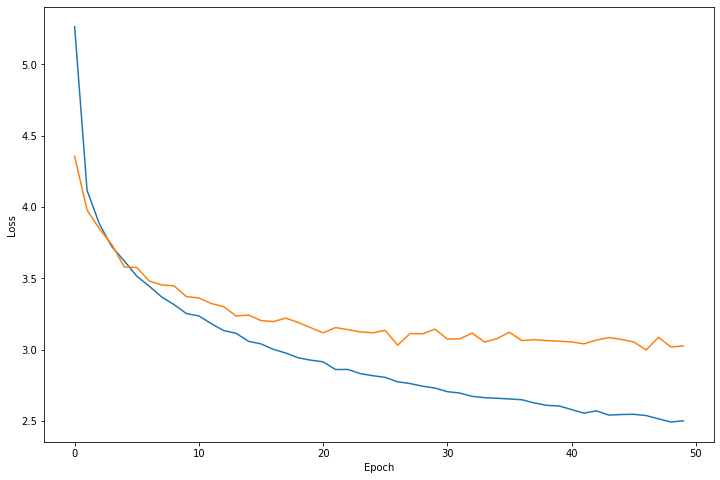

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(test_losses)), test_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

После обучения вам (и нам) захочется оценить, что же получилось. Давайте научимся генерировать подпись к заданной картинке и считать BLEU по тестовому корпусу. Извините, я вам соврал, в домашке все же будет парочка небольших заготовок кода:

In [ ]:
def generate(image_tensor):
    imshow(image_tensor)
    
    caption_model.eval()
    with torch.no_grad():
        words = caption_model.generate_caption(torch.unsqueeze(image_tensor.to(DEVICE), 0))
        
    return " ".join(words)

a young girl in a pink bathing suit is jumping into a swimming pool <unk> <end>
<start> a child wearing purple runs through splashing water while a man in red looks on <unk> <end> <pad> <pad>


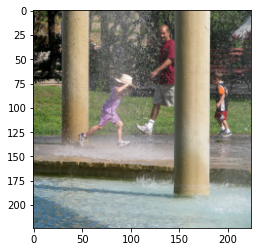

In [ ]:
image_tensor = val_dataset[15][0]
true_caption = val_dataset[15][1].numpy()
tokens = [vocab.idx2word[int(idx)] for idx in true_caption[0]]

print(generate(image_tensor))
print(" ".join(tokens))

In [ ]:
from torchtext.data.metrics import bleu_score

def get_bleu(model):
    predictions = []
    references = []
    with torch.no_grad():
      for test_file in test_dataset:
        img, descr = test_file
        caption = model.generate_caption(torch.unsqueeze(img.to(DEVICE), 0))
        predictions.append(caption[:-1])
        references.append(descr)

    return bleu_score(predictions, references)

bleu_res = get_bleu(caption_model)
print(bleu_res)

0.12590685486793518




---



## Внимание, attention! (4 балла)

Теперь добавим attention в нашу модель. Вопрос в том, куда же нам его добавлять! Раньше мы annentились на слова исходной последовательности, но сейчас вместо последовательности у нас картинка...

Но ведь промежуточное представление картинки в сверточной сети имеет размеры (H x W x С), причем на большой глубине H и W сравнительно небольшие. Давайте "отрежем" от сети ещё чуть дальше головы, например, последний пулинг, и полученные векторы размера C будем считать теми самыми "словами исходной последовательности". Если вы использовали InceptionV3, то H=W=8, т.е. "длина последовательности" равна 64. Прочитать про это подробнее вы можете в оригинальной [статье](http://kelvinxu.github.io/projects/capgen.html).

![](https://cdn-images-1.medium.com/max/2000/0*YCeQbqU6CVxzpave.)  
*From [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)*

В качестве энкодера по-прежнему будет выступать сверточная сеть. Модель теперь должна научиться генерировать маску внимания на каждом шаге:

![](http://kelvinxu.github.io/projects/diags/model_diag.png)  
*From [http://kelvinxu.github.io/projects/capgen.html](http://kelvinxu.github.io/projects/capgen.html)*


На лекции мы рассматривали три варианта attention. Предлагается сначала реализовать любой из них и получить 2 балла, затем по 1 баллу за каждый следующий.

Также вам нужно реализовать визуализацию работы attention как на картинке выше.



In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

Реализуем 3 вида attention из лекций:

In [ ]:
import torch.nn.functional as F

class MultiAttention(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(MultiAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)
                
    def forward(self, features, hidden):

        hidden = hidden.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(hidden)

        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)

        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight

In [ ]:
#Dot Attention работает только в случае совпадения hidden_size c 2048 (количеством признаков)

class DotAttention(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, attentions, hidden):

        logits= attentions @ (hidden.permute(1,2,0))
        scores = torch.softmax(logits, dim=1)
        return torch.sum(scores*attentions, dim=1)

class MultiplicativeAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.linear = nn.Linear(2048, hidden_dim)
        
    def forward(self, attentions, hidden):
        batch_size, att_dim, hidden_size = attentions.shape
        batch_size, hidden_size = hidden.shape
        logits = []
        for i in range(batch_size):
          logit = (self.linear(attentions[i,:,:]) @ hidden[i,:]).reshape(64,1)
          logits.append(torch.unsqueeze(torch.softmax(logit, dim=1) * attentions[i,:,:], 0))

        logits = torch.cat(logits, dim=0)

        return torch.sum(logits, dim=1)

Добавим attention в нашу модель:

In [ ]:
from torchvision import models

class AttEncoderCNN(nn.Module):
    def __init__(self):
        super(AttEncoderCNN, self).__init__()
        self.inception = models.inception_v3(pretrained = True, aux_logits = False)
        for param in self.inception.parameters():
            param.requires_grad = False

        self.inception.fc = Identity()
        self.inception.avgpool = Identity()

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        features = self.inception(x)
        batch_size, _ = features.shape
        features = self.inception(x).reshape(batch_size, 2048, 8, 8)
        features = features.permute(0,2,3,1).reshape(batch_size,64, 2048)

        return self.dropout(self.relu(features))


class AttDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(AttDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTMCell(embedding_dim + 2048, hidden_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(2048, hidden_dim)

        self.attention = MultiAttention(2048, hidden_dim)

    def forward(self, features, descriptions):

        descriptions = torch.squeeze(descriptions)
        
        embed_x = self.dropout(self.embedding(descriptions))
        batch_size, c, hidden_size = features.shape
        batch_size, seq_len, input = embed_x.shape

        h_0 = self.linear2(torch.mean(features, dim=1))
        c_0 = h_0

        hiddens=[]
        for i in range(seq_len):
          h_0_att, _ = self.attention(features, h_0)
          input = torch.cat((embed_x[:,i,:], h_0_att), dim=1)         
          
          (h_0, c_0) = self.lstm(input, (h_0, c_0))

          hiddens.append(torch.unsqueeze(h_0, 1))
          
        outputs = self.linear(torch.cat(hiddens, dim=1))
        return outputs

class MySuperModelAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(MySuperModelAttention, self).__init__()

        self.encoder = AttEncoderCNN()
        self.decoder = AttDecoderRNN(vocab_size, embedding_dim, hidden_dim)
        
    def forward(self, images, descriptions):
        features = self.encoder(images)
        output = self.decoder(features, descriptions)
        return output

    def generate_caption(self, image, max_lenght = 20):
        features = self.encoder(image)
        res = []
        attentions = []

        batch_size, c, hidden_size = features.shape
        h_0 = self.decoder.linear2(torch.mean(features, dim=1))    
        c_0 = h_0

        last_token = torch.LongTensor([vocab('<start>')]).to(DEVICE)
        last_token = self.decoder.embedding(last_token).reshape(1,-1)

        for i in range(max_lenght):
            h_0_att, att_weights = self.decoder.attention(features, h_0)
            input = torch.cat((last_token, h_0_att), dim=1)
            (h_0, c_0) = self.decoder.lstm(input, (h_0, c_0))
    
            attentions.append(torch.sum(features*(att_weights.reshape(1,64,1)), dim=1))
            output = self.decoder.linear(h_0)
            predicted = output.argmax(1)
            res.append(predicted.item())
            last_token = self.decoder.embedding(predicted)
            if vocab.idx2word[predicted.item()] == '<end>':
              break
          
        words = [vocab.idx2word[word] for word in res]  


        return attentions, words

Аналогичный цикл обучения:

In [ ]:
def train_att_model(model, optimizer, loss_func, train_loader, test_loader,  max_epochs, losses=None, curr_epoch=0):
    if losses is None:
      losses = {"train": [], "test": []}

    for epoch in range(curr_epoch, max_epochs):
          ep_train_loss = []
          ep_test_loss = []
          pbar = tqdm(train_loader, total=len(train_loader), leave=False)
          pbar.set_description(f"Epoch {epoch + 1}")
          for x_batch, y_batch in pbar:
              model.train(True)
              x_batch = x_batch.to(DEVICE)
              y_batch = y_batch.to(DEVICE)

              optimizer.zero_grad()
              outp = model.forward(x_batch, y_batch)
              batch_size, seq_len, vocab_size = outp.shape

              pred = outp[:, :-1, :].reshape(batch_size * (seq_len - 1), vocab_size)
              target = (y_batch[:,0])[:, 1:].reshape(batch_size * (seq_len - 1))

              loss = loss_func(pred, target)
              loss.backward()
              optimizer.step()

              ep_train_loss.append(loss.item())


          model.train(False)

          print("Validation: ")
          for x_batch, y_batch in tqdm(test_loader):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outp = model.forward(x_batch, y_batch).detach()

            batch_size, seq_len, vocab_size = outp.shape

            x_batch = x_batch.detach()
            y_batch = y_batch.detach()

            pred = outp[:, :-1, :].reshape(batch_size * (seq_len - 1), vocab_size)

            target = (y_batch[:,0])[:, 1:].reshape(batch_size * (seq_len - 1))

            loss = loss_func(pred, target)
            ep_test_loss.append(loss.item())
            if len(ep_test_loss) % 2 == 0:
              _, caption = model.generate_caption(torch.unsqueeze(x_batch[0].to(DEVICE), 0))
              true_caption = y_batch[0]
              tokens = [vocab.idx2word[int(idx)] for idx in true_caption[0]]
              print("Predicted caption: ", " ".join(caption))
              print("Real caption: ", " ".join(tokens))

          print('Epoch: ', epoch + 1)
          print('Train loss: ', np.mean(ep_train_loss))
          print('Test loss: ', np.mean(ep_test_loss))

          losses['train'].append(np.mean(ep_train_loss))
          losses['test'].append(np.mean(ep_test_loss))
          if (epoch + 1) % 1 == 0:
            state = {'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses['train'],
            'test_loss': losses['test']}
            torch.save(state, f"model_{epoch + 1}_epochs.pth")

    return losses['train'], losses['test']

In [ ]:
vocab_size = len(vocab)
max_epochs = 50
batch_size = 32
hidden_size = 256

caption_model =  MySuperModelAttention(vocab_size=vocab_size, embedding_dim=300, hidden_dim=hidden_size)

caption_model.to(DEVICE)
optimizer = torch.optim.Adam(caption_model.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))

In [ ]:
!cp '/content/gdrive/My Drive/ABBYY/model_45_epochs.pth' model.pth

In [ ]:
state = torch.load(os.path.join("model.pth"))

caption_model =  MySuperModelAttention(vocab_size=vocab_size, embedding_dim=300, hidden_dim=hidden_size)
caption_model.to(DEVICE)

optimizer = torch.optim.Adam(caption_model.parameters(), lr=5e-4)

train_losses = state['train_loss']
test_losses = state['test_loss']

caption_model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])

epoch = state['epoch'] + 1

losses = {"train": train_losses, "test": test_losses}

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
train_losses, test_losses = train_att_model(caption_model, optimizer, loss_func, train_loader, val_loader,  max_epochs, losses, epoch)

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a red shirt is riding a trick on a track . <end>
Real caption:  <start> a skateboarder executes a jump in a skate park . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black and white shirt is sitting on a sidewalk . <end>
Real caption:  <start> a man holding a bottle of wine with a box on his head <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a white dog is running through the water . <end>
Real caption:  <start> two large seagulls are in the water . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is riding a skateboard . <end>
Real caption:  <start> people hang upside down as a roller coaster executes a spiral <unk> . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt and a black and white shirt is standing on a sidewalk . <end>
Real caption:  <start> an older man does the splits on a hardwood floor . <end> <pad> <pad> <pad>

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a black dog is running through the snow . <end>
Real caption:  <start> two black dogs are fighting over a toy <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is jumping over a ramp . <end>
Real caption:  <start> men in a <unk> tent outside in a rundown area . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the grass . <end>
Real caption:  <start> a man in a brown vest and glasses plays with a brown dog . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is standing on a snowy mountain . <end>
Real caption:  <start> the person is standing by the water in front of the snow topped mountains . <end> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt and a black and white shirt is standing on a street . <end>
Real caption:  <start> two teenage girls are texting in the park . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption: 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a boy in a red shirt and a red shirt is jumping over a park . <end>
Real caption:  <start> three children stand on or near a fence . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is jumping into the water . <end>
Real caption:  <start> a child on a rock in a stream . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a blue shirt is riding a bike on a bike . <end>
Real caption:  <start> a biker rides down the street . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is standing on a snowy hill . <end>
Real caption:  <start> three people on red boats paddle through water with mountains in the background . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people are sitting on a street . <end>
Real caption:  <start> a crowd watching a skateboarder . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predic

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a group of people are standing on a bench . <end>
Real caption:  <start> a kid kicking a large ball while surrounded by other kids . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is standing on a bench . <end>
Real caption:  <start> a youth in red swim trunks jumps into the water from a wooden board . <end> <pad> <pad> <pad>
Predicted caption:  a young girl is sitting on a bench with a red and white dog . <end>
Real caption:  <start> four young children pose in formally for an informal picture . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people are playing in a field . <end>
Real caption:  <start> four young kids have a picture taken of them while in midair . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a skier is standing on a snowy mountain . <end>
Real caption:  <start> a snowboarder takes a ramp made of snow while others watch . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a ma

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a red shirt is running on a beach . <end>
Real caption:  <start> a seated woman with short hair and a camera throws a frisbee to a brown dog . <end> <pad>
Predicted caption:  a man is sitting on a bench . <end>
Real caption:  <start> a woman is throwing a bucket of water over a baby in the paddling pool . <end> <pad> <pad>
Predicted caption:  a man in a white shirt is standing on a bench . <end>
Real caption:  <start> two older women and a little girl standing outside under flowers . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a brown dog is running through the grass . <end>
Real caption:  <start> this dog is running along the path . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt is standing on a bench . <end>
Real caption:  <start> woman holding a baby shopping for books <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is r

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a white shirt is jumping over a tree . <end>
Real caption:  <start> an elderly woman sits on a tree stump with a white dog . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people are playing in the air . <end>
Real caption:  <start> two cowboys rope a steer from horseback in an indoor corral . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young boy is sitting on a bench with a red and white dog . <end>
Real caption:  <start> a small child in an izod shirt holds a cellphone to her ear . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a red shirt is standing on a sidewalk . <end>
Real caption:  <start> a man in american flag shorts stands at the top of the stairs . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is running through the water . <end>
Real caption:  <start> a black dog with a red collar is jumping out of the water . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is r

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  two men are playing in the water . <end>
Real caption:  <start> a boy flings sand at a girl . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is jumping over a hill . <end>
Real caption:  <start> a woman biking along a trail surrounded by various plants . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the snow . <end>
Real caption:  <start> a black and white dog is running through the sand on a beach . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a black and white dog is running through the grass . <end>
Real caption:  <start> a black and white dog bounds through tall wheat grass . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a boy in a red uniform is running on the grass . <end>
Real caption:  <start> the woman lacrosse player in blue is about to catch the ball . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is sitting on a bench . <

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a group of people are sitting on a bench . <end>
Real caption:  <start> two men drinking beers at a table <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people are sitting in a white and white shirt . <end>
Real caption:  <start> the bride and groom are getting served a drink at their wedding reception . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a young girl is sitting on a bench . <end>
Real caption:  <start> a girl dumps a bucket of water on another girl . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is riding a bike on a bike . <end>
Real caption:  <start> a young man is performing a bicycle jump on a ramp . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a white shirt and a white shirt and a woman . <end>
Real caption:  <start> girls with orange hair standing on the street with some kind of bottle in their hand . <end> <pad>
Predicted caption:  a

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a hat and a hat and a hat . <end>
Real caption:  <start> a small boy wearing glasses and a hat is looking at something and smiling . <end> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt and a black shirt and a black shirt and a black shirt and a
Real caption:  <start> the man is carrying several cases while riding a skateboard . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the grass . <end>
Real caption:  <start> a tan dog hangong on to a white plushie toy . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the snow . <end>
Real caption:  <start> five dogs pull a man on a sled through the snow . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt and a black hat . <end>
Real caption:  <start> a man in an orange safety suit spraying water . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a blue shirt is standing in front of a crowd . <end>
Real caption:  <start> a man is wearing a blue shirt that is rolled up above his abdomen . <end> <pad> <pad> <pad>
Predicted caption:  a woman with a black and white shirt is sitting on a bench . <end>
Real caption:  <start> an old woman is sitting next to a young girl with her fingers in her mouth . <end> <pad>
Predicted caption:  a man is jumping over a white dog . <end>
Real caption:  <start> a man in a safety suit training a police german shephard . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two dogs are running on a grassy field . <end>
Real caption:  <start> two dogs play together on the grass in front of a small stone well . <end> <pad> <pad> <pad>
Predicted caption:  a young girl in a blue shirt is jumping over a tree . <end>
Real caption:  <start> a small child is in a tree wearing red shoes . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is jumping 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a young girl in a pink shirt is sitting on a bench . <end>
Real caption:  <start> a child in a blue shirt sitting on a forest floor , looking through binoculars . <end> <pad> <pad>
Predicted caption:  a boy in a red shirt and a red shirt is playing with a tennis ball . <end>
Real caption:  <start> the tennis player in the blue shirt is holding his racquet up in the air . <end> <pad> <pad>
Predicted caption:  a man is standing on a bench near a city street . <end>
Real caption:  <start> people using an outdoor ice skating rink . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a blue shirt is standing on the beach . <end>
Real caption:  <start> the small baby in a yellow has the lower half of her body buried in sand . <end> <pad>
Predicted caption:  a man is sitting on a bench in a park . <end>
Real caption:  <start> a woman dumping water on a small child who is in a pool <end> <pad> <pad> <pad> <pad> <pad>
Predicted ca

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man is sitting on a lake . <end>
Real caption:  <start> a boy in a red shirt sits on a rock on the edge of a river . <end> <pad>
Predicted caption:  a black dog is running through the grass . <end>
Real caption:  <start> a black dog with an orange toy in its mouth is walking in fall leaves . <end> <pad> <pad>
Predicted caption:  a group of children are playing in a field . <end>
Real caption:  <start> a girl runs through an obstacle course outside as some boys watch . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a red shirt and a black hat and a woman in a red shirt . <end>
Real caption:  <start> a violinist and a singer perform in front of people . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a tennis player is playing tennis . <end>
Real caption:  <start> a tennis player in a green striped shirt is holding his hand up to his mouth . <end> <pad>
Predicted caption:  a man is standing on a bench near a tree . <end>
Real 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  two boys are playing soccer . <end>
Real caption:  <start> a young boy and girl playing . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt and a black shirt and a black jacket . <end>
Real caption:  <start> the man is wearing a backpack and sunglasses while walking through an outdoor market . <end> <pad> <pad> <pad>
Predicted caption:  a man is standing in a lake . <end>
Real caption:  <start> a bald eagle stands in shallow water . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a white shirt and a white shirt and a woman are sitting on a bench . <end>
Real caption:  <start> the person with the tattoos is holding a dirty frying pan . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two women in a white dress and a brown and white dog . <end>
Real caption:  <start> a group of people in anime cosplay costumes . <end> <pad> <pad> <pad> <pad> <pa

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man is riding a surfboard on a beach . <end>
Real caption:  <start> a man windsurfs , putting his off hand into the water . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is running through the grass . <end>
Real caption:  <start> a black dog and a brown dog are playing rough on green grass . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people are standing on a sidewalk . <end>
Real caption:  <start> people walk through a square . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the snow . <end>
Real caption:  <start> a brown and black dog running through <unk> ground . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a little girl in a red shirt and a black shirt is sitting on a bench . <end>
Real caption:  <start> a little blonde girl stands on a pink skateboard . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predi

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man sits on a bench . <end>
Real caption:  <start> several people are sitting at a table drinking wine . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a white shirt and jeans is walking down a street . <end>
Real caption:  <start> a man races another man in the background <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and a woman are sitting on a bench . <end>
Real caption:  <start> a man sitting on a couch holding a baby , surrounded by three young girls . <end> <pad> <pad>
Predicted caption:  a man in a white shirt is climbing a rock . <end>
Real caption:  <start> a boy jumps off a tan rock . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is doing a trick on a skateboard . <end>
Real caption:  <start> a group of cheerleaders are lifting up two other cheerleaders above their heads . <end> <pad> <pad> <pad> <pad>
Predicted c

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man is standing on a bench . <end>
Real caption:  <start> a helicopter is flying behind a plane that is performing aerobatics . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people are walking along the beach . <end>
Real caption:  <start> three men stand on the beach , fully clothed . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a black dog is running through the grass . <end>
Real caption:  <start> a large dog runs through a field in the rain . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a girl in a pink shirt is playing with a woman in a pool . <end>
Real caption:  <start> kids swimming underwater in the pool . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young girl wearing a blue shirt is holding a baby . <end>
Real caption:  <start> blonde girl with pink top smiling while wearing funny glasses with large nose . <end> <pad> <pad> <pa

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a baby in a red shirt is sitting on a bench . <end>
Real caption:  <start> a small child kissing a cat on the kitchen counter . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a person in a red jacket is riding a bike on a dirt bike . <end>
Real caption:  <start> a small child racing down a snowy hill on an innertube <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two dogs are playing in the snow . <end>
Real caption:  <start> two dogs play in the snow <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through a grassy area . <end>
Real caption:  <start> a woman in a black sweatshirt is walking on a dock with a wet dog . <end> <pad> <pad>
Predicted caption:  a woman in a pink dress and a white dress and a woman . <end>
Real caption:  <start> young girl in ponytail pets furry cat <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted capt

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a woman in a white shirt and a black hat and a black jacket is running on the beach .
Real caption:  <start> two small children walk down a sandy beach . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two dogs are running through the snow . <end>
Real caption:  <start> three dogs race in the snow together . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black jacket is sitting on a bench . <end>
Real caption:  <start> the soldier looks out the window as he sits with his legs crossed . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a person in a blue shirt is riding a bike down a hill . <end>
Real caption:  <start> a guy is doing a bike trick in a park . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a white dog is jumping over a hurdle . <end>
Real caption:  <start> white greyhound racing as dog number 1 . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a red shirt is doing a trick on a crowd . <end>
Real caption:  <start> a skateboarder performs a trick in front of a large crowd . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the grass . <end>
Real caption:  <start> a little white and tan dog running through the grass with a stick in his mouth . <end> <pad>
Predicted caption:  a black and white dog is running through the grass . <end>
Real caption:  <start> a dog shakes off water and gets contorted . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the water . <end>
Real caption:  <start> a black dog splashes in the water <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a girl in a pink shirt is running on a grassy field . <end>
Real caption:  <start> four children are running and playing tag . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicte

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a woman in a black and white suit and a black hat and a black jacket . <end>
Real caption:  <start> girls sit on benches . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a black shirt and a black hat and a black hat and a woman . <end>
Real caption:  <start> a man carries a sign while standing in the rain . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two dogs are running on the grass . <end>
Real caption:  <start> a light brown dog and a black and brown dog are in some dry brush . <end> <pad> <pad>
Predicted caption:  a dog jumps over a log . <end>
Real caption:  <start> a dog jumping high into the air in the country . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is jumping through the snow . <end>
Real caption:  <start> dog on leash burrows into snow in rural area . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog w

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a group of people are standing in front of a city street . <end>
Real caption:  <start> a man and woman walking down the street . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog runs through the snow . <end>
Real caption:  <start> a dog is preparing to run away from a person interacting with it . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a brown dog is jumping into the water . <end>
Real caption:  <start> a dog jumps into a backyard pool . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a black and white dress is walking past a picture . <end>
Real caption:  <start> three high school girls walk and talk on astroturf . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red jacket is skiing down a snowy hill . <end>
Real caption:  <start> skiers in uniform progress down a snowy slope . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  two dogs are playing in the sand . <end>
Real caption:  <start> three dogs running in the dirt . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a boy in a red shirt is surfing on the beach . <end>
Real caption:  <start> a girl in a bathing suit plays on the surf . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through a large puddle . <end>
Real caption:  <start> two dogs are running up a woodland path . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through the water . <end>
Real caption:  <start> a black dog with a red collar is walking through water . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man rides a bike down a hill . <end>
Real caption:  <start> a mountain biker is riding along a heavy dirt trail in a wooded area . <end> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt and a black shirt and a 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a boy in a red jacket is jumping over a snowy hill . <end>
Real caption:  <start> two people on a sled riding down a snowy hill . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of horses are riding horses on a track . <end>
Real caption:  <start> two cowboys on horseback lasso a young calf to the ground . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black coat and a black shirt is standing on a cellphone . <end>
Real caption:  <start> an adult male wearing a backpack walks and looks to the left . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a brown dog is jumping into the water . <end>
Real caption:  <start> a dog jumps into a backyard pool . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a boy in a red shirt is jumping over a wooden fence . <end>
Real caption:  <start> the three children are standing on and by a fence . <end> <pad> <pad> <pad> <pad> <pad> <pad

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a white dog is running through the grass . <end>
Real caption:  <start> a small dog runs through the grass . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is standing on a sidewalk . <end>
Real caption:  <start> two people are standing outside of a coffee house . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a white bird is flying over water . <end>
Real caption:  <start> a large gray bird begins to land in the water . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a girl in a red shirt and a red shirt is jumping over a fence . <end>
Real caption:  <start> the little boy is smiling as he crosses a rope on an assault course . <end> <pad> <pad> <pad>
Predicted caption:  a little boy is sitting on a bed . <end>
Real caption:  <start> a kid climbs through a small door . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man i

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a woman in a pink dress and a woman walking down the street . <end>
Real caption:  <start> a woman dressed up walks down the sidewalk with her back turned . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young girl in a bikini is sitting on the beach . <end>
Real caption:  <start> young lady in bikini lying on the beach <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man climbing a rock face . <end>
Real caption:  <start> a man climbs a mountain . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt and jeans is standing on a sidewalk . <end>
Real caption:  <start> man playing musical instrument standing beside a yellow and red fire hydrant <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a pink shirt is walking on a beach . <end>
Real caption:  <start> surfers line up in the water awaiting the next wave . <end> <pad> <pad> <pa

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a boy in a red shirt is jumping over a fence . <end>
Real caption:  <start> three children stand on or near a fence . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man with a black shirt and a woman in a white shirt and a black shirt . <end>
Real caption:  <start> a serious looking boy with glasses and a blue shirt poses . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a child in a red jacket is running through the snow . <end>
Real caption:  <start> two kids play with plastic shovels in a snowy pond . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt and a crowd of people . <end>
Real caption:  <start> a man with glasses and a grey shirt is on a crowded street . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a little girl in a blue shirt is jumping on a bed . <end>
Real caption:  <start> a little blonde girl crawling into a blue inflatable bouncy house . <end> <pad> <pad>

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a dog jumps over a tree . <end>
Real caption:  <start> two large dogs are playing in a large grassy area . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a white shirt and a tennis ball . <end>
Real caption:  <start> a woman playing tennis preparing to serve the ball . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two girls are playing in a field . <end>
Real caption:  <start> the little girl tackles a man and makes the universal sign for " touchdown ! " <end> <pad> <pad>
Predicted caption:  a man and a woman are standing in front of a building . <end>
Real caption:  <start> two asian ladies posing for a picture . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a brown dog is running through a field . <end>
Real caption:  <start> a dog jumps high while outside . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a boy in a blue shi

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man is sitting on a bench . <end>
Real caption:  <start> a dog is jumping through a fiery obstacle . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is sitting on a bed . <end>
Real caption:  <start> a young blonde boy is jumping from bed to bed . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people sit on a bench . <end>
Real caption:  <start> a young girl at a card table selling lemonade and watermelon . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is riding a skateboard on a skateboard . <end>
Real caption:  <start> a white race dog wearing the number eight runs on the track . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two children are playing in a fountain . <end>
Real caption:  <start> a group of young naked children showering outside <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is sitting on a bench . <end>

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man and a woman are posing for a picture . <end>
Real caption:  <start> three people pose for a picture . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt is standing on a tree stump . <end>
Real caption:  <start> a smiling boy kneeling in a forest . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a black shirt is sitting on a bench . <end>
Real caption:  <start> an older man does the splits on a hardwood floor . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a white shirt is sitting on a wall . <end>
Real caption:  <start> a man points to a blackboard to show a child something . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and woman are standing in front of a store . <end>
Real caption:  <start> two women and child eat ice cream cones on bridge decorated with flowers . <end> <pad> <pad> <pad> <pad>
Pre

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a group of people are riding a small child on a beach . <end>
Real caption:  <start> four young men are running on a street and jumping for joy . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a subway car is walking down a subway . <end>
Real caption:  <start> two people are sitting on the bus at nighttime . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a girl in a blue shirt is swimming underwater . <end>
Real caption:  <start> a young boy in a pool playing with a green water gun <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man and a woman are standing outside . <end>
Real caption:  <start> <unk> man in casual clothes looking off camera . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a boy jumps off a ramp . <end>
Real caption:  <start> a man jumping a rail on his skateboard . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a child in a red shirt is swinging on a swing . <end>
Real caption:  <start> a child rides a swing . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is sitting on a bench with a white dog . <end>
Real caption:  <start> two men in robes wave at an approaching jeep traveling through the sand . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a man and a woman are playing with a man in a black and black dog . <end>
Real caption:  <start> the little boy stands in the middle of birds who have gathered on the sidewalk . <end> <pad> <pad>
Predicted caption:  a man rides a bike down a dirt path . <end>
Real caption:  <start> a bicyclist with a green shirt rides through the woods <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red hat and a hat and a hat . <end>
Real caption:  <start> black men in poor neighborhood . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a black coat and a hat . <end>
Real caption:  <start> two men are posing for a picture . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of people in a parade . <end>
Real caption:  <start> a crowd of people watching a snowboarder do tricks . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a helmet rides a bike on a bike . <end>
Real caption:  <start> a woman rides her bike by some trees . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young boy wearing a blue shirt and a black shirt and a black shirt . <end>
Real caption:  <start> a little girl is talking on a cellphone on the floor of a living room . <end> <pad> <pad>
Predicted caption:  a dog is playing with a ball in a yard . <end>
Real caption:  <start> a woman in a black hooded sweatshirt walking with a large dog . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a skier is skiing

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a white shirt and jeans is walking down a sidewalk . <end>
Real caption:  <start> several people are running quickly through a parking lot . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog swimming in the water . <end>
Real caption:  <start> a brown dog swimming in murky water . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young boy is standing on a green bench . <end>
Real caption:  <start> a little blond girl with a pink coat hides in a tree . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog is running through a grassy field . <end>
Real caption:  <start> a dachshund returning a tennis ball . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man with a helmet and a helmet and a helmet . <end>
Real caption:  <start> a train blowing smoke . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Pred

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a brown dog is jumping through a grassy field . <end>
Real caption:  <start> a greyhound jumps over a chain . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a white dog is running on the beach . <end>
Real caption:  <start> two dogs playing rough . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog runs through the grass . <end>
Real caption:  <start> the dog is running through the yard . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a yellow kayak in a kayak . <end>
Real caption:  <start> a kayaker in a red kayak paddles as an orange kayak approaches from behind . <end> <pad> <pad> <pad>
Predicted caption:  a woman in a white dress is sitting on a chair . <end>
Real caption:  <start> a person eats takeout while watching a small television . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man wearing a helmet and a helmet is riding a bike . <end>
Real caption:  <start> punk rock teenager walks with a mean look on his face . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a basketball player is holding a basketball . <end>
Real caption:  <start> little boy playing basketball in the grass <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a group of children are standing in front of a large group of people . <end>
Real caption:  <start> a little girl is in a crowd of people holding a rope attached to a sheep . <end> <pad>
Predicted caption:  a biker rides a bike in the air . <end>
Real caption:  <start> a person stunt riding on a bmx type of bicycle . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a basketball player in white is challenging the ball . <end>
Real caption:  <start> two men jump for the basketball . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a green shirt is walking through a grassy area . <end>
Real caption:  <start> woman on bicycle riding down dirt trail . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a red shirt and helmet rides a bike . <end>
Real caption:  <start> a small boy wearing a red helmet rides his bicycle down a patterned path . <end> <pad> <pad> <pad>
Predicted caption:  a man in a white shirt and jeans is standing on a field . <end>
Real caption:  <start> a soccer player is kicking a soccer ball . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two people are sitting in the water . <end>
Real caption:  <start> a woman walks by a river across city buildings . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a boy is jumping into the water . <end>
Real caption:  <start> a little boy is jumping in front of a fountain . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a black dog is running through the grass . <end>
Real caption:  <start> a black dog with a green collar holds a red and blue object in its mouth . <end> <pad>
Predicted caption:  a white dog is running through a field of a tree . <end>
Real caption:  <start> a small white dog pulls a large stick out of the water . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a blue shirt is standing in front of a store . <end>
Real caption:  <start> a man and woman are looking at an exhibit entitled ' other people <unk> photographs ' . <end> <pad>
Predicted caption:  a boy is jumping off a ramp . <end>
Real caption:  <start> a boy does a trick on his bike as other kids watch . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a blue shirt rides a bike on a dirt bike . <end>
Real caption:  <start> a cyclist in a midair jump . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two boys are playing soccer in a 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man in a boat is riding a boat on a boat . <end>
Real caption:  <start> person in pointed hat and face covered with green scarf poling boatload of stuff through water <end> <pad> <pad>
Predicted caption:  a woman with a mohawk and a blue shirt is smiling . <end>
Real caption:  <start> a girl with red hair and red eyebrows appears to be in <unk> . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a black and white dog is running through a grassy field . <end>
Real caption:  <start> two dogs wrestle in a field . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man in a blue shirt and a blue shirt is playing with a ball . <end>
Real caption:  <start> four boys on a black top with a green and yellow basketball . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a skateboarder is doing a trick on a skateboard . <end>
Real caption:  <start> a kid is skateboarding on a handrail . <end> <pad> <pad> <pad> <pad> <pad> <pad>

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man is riding a bike on a bike . <end>
Real caption:  <start> a group of people ride bikes while holding onto large trash bags . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a white dress is standing next to a woman in a white dress . <end>
Real caption:  <start> a woman wearing a white shirt stands on the street . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a brown dog with a red collar is playing in the grass . <end>
Real caption:  <start> a brown dog is running through <unk> water carrying a tennis ball . <end> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a red coat is walking through the snow . <end>
Real caption:  <start> two young kids wearing winter coats play in the snow . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a tennis player hitting a tennis ball . <end>
Real caption:  <start> a tennis player wearing a green shirt about to hit a ball with his racquet . <end> <pad> 

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a girl in a red shirt is sitting on a bed . <end>
Real caption:  <start> a little girl in pink stands in a yellow hallway . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a girl in a pink dress is blowing bubbles . <end>
Real caption:  <start> a little girl in a pick dress hula hoops with her neck outside . <end> <pad> <pad> <pad> <pad>
Predicted caption:  a boy in a blue shirt is sitting on a green slide . <end>
Real caption:  <start> a toddler is sitting inside a yellow tunnel in the playground . <end> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is riding a bicycle on a bike . <end>
Real caption:  <start> boy in midair on bicycle <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a dog runs through the grass . <end>
Real caption:  <start> a yellow labrador running with its ears flopping . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  two do

  0%|          | 0/187 [00:00<?, ?it/s]

Validation: 


  0%|          | 0/31 [00:00<?, ?it/s]

Predicted caption:  a man on a motorcycle and a woman wearing a helmet . <end>
Real caption:  <start> a man in a black and red jacket and helmet does a stunt on a motorbike . <end> <pad>
Predicted caption:  a mountain biker is riding a mountain bike . <end>
Real caption:  <start> beautiful snowy landscape with people treading through the snow . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a young boy in a red shirt and shorts is playing soccer . <end>
Real caption:  <start> a person throwing a yellow ball in the air . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a man is standing on a bench in front of a building . <end>
Real caption:  <start> a man jumps off a large building onto the ground . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted caption:  a woman in a white shirt and a white shirt is standing on a rock wall . <end>
Real caption:  <start> a woman in purple with two children in the mouth of a cave . <end> <pa

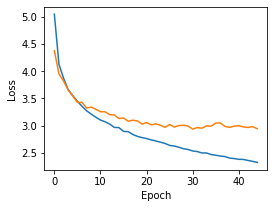

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(test_losses)), test_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
from skimage.transform import resize

def visualize(model, dataset, image_index):

    model.eval()
    image_tensors = dataset[image_index][0].to(DEVICE).detach()

    figure = plt.figure(figsize=(15, 20))
    attentions, words = model.generate_caption(torch.unsqueeze(image_tensors, 0))

    image_path = dataset.keys[image_index] + '.jpg'
    image = plt.imread('Flicker8k_Dataset/' + image_path)
    image = resize(image, (299, 299)).astype('float32') / 255.

    image_tensors = image_tensors.cpu().detach()

    for ind, (attention, word) in enumerate(zip(attentions, words)):
        attention = attention.reshape(32,64).cpu().detach().numpy()
        ax = figure.add_subplot(np.ceil(len(words) / 3.), 3, ind + 1)

        ax.text(0, 1, word, color='black', backgroundcolor='white', fontsize=12)
        imshow(image_tensors)

        alpha = resize(1 - attention, (192, 192))

        ax.imshow(alpha, alpha=0.7)
        ax.axis('off')

In [ ]:
def generate(image_tensor):
    imshow(image_tensor)
    
    caption_model.eval()
    with torch.no_grad():
        _, words = caption_model.generate_caption(torch.unsqueeze(image_tensor.to(DEVICE), 0))
        
    return " ".join(words)

a boy in a yellow shirt is playing with a toy in the background . <end>
<start> a laughing child is holding a water gun and getting sprayed with water . <end> <pad> <pad> <pad> <pad>


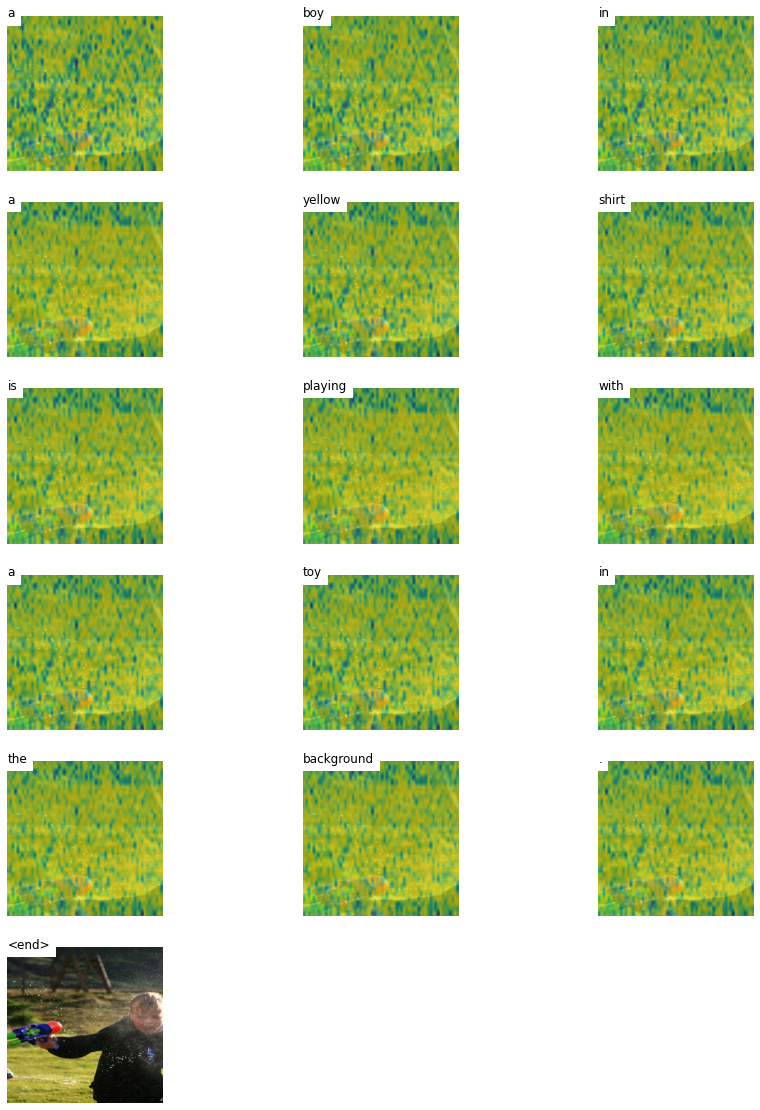

In [ ]:
image_index = 10

image_tensor = val_dataset[image_index][0]
true_caption = val_dataset[image_index][1].numpy()
tokens = [vocab.idx2word[int(idx)] for idx in true_caption[0]]


visualize(caption_model, val_dataset, image_index)

print(generate(image_tensor))
print(" ".join(tokens))

Как видим, качество немного выше по сравнению с предыдущей моделью

In [ ]:
from torchtext.data.metrics import bleu_score

def get_bleu(model):
    predictions = []
    references = []
    with torch.no_grad():
      for test_file in test_dataset:
        img, descr = test_file
        _, caption = model.generate_caption(torch.unsqueeze(img.to(DEVICE), 0))
        predictions.append(caption[:-1])
        references.append(descr)

    return bleu_score(predictions, references)

bleu_res = get_bleu(caption_model)
print(bleu_res)

0.1641959579002405


## Бонусы (до 5 баллов до дедлайна)

Как обычно, вам предлагается по желанию продолжить эксперименты.

## Сдача
https://forms.gle/mqanqu6JKHTpf78GA



---



Просто пример работы с чекпойнтами

In [ ]:
model_name = f'model{0}'
epoch = 
# checkpoint = torch.load(os.path.join('./checkpoints', model_name, f'{model_name}#{epoch}.pt'))
checkpoint = torch.load(os.path.join(f'{model_name}.pt'))

# Создаём те же классы, что и внутри чекпоинта
model, optimizer = create_model_and_optimizer(
    ...
)

scheduler = ...

# Загружаем состояния из чекпоинта
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['losses']